In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

In [16]:
import warnings
##register matplotlib datetime warnings
sns.set()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (100, 50),
         'axes.labelsize': 50,
         'axes.titlesize':70,
         'xtick.labelsize':25,
         'ytick.labelsize':25}
plt.rcParams.update(params)
#plt.rcParams["figure.figsize"] = (50,20)  ##Define plotting size
#plt.rcParams["figure.figsize"] = (50,20)  ##Define plotting size

warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Dataset

In [3]:
phishing_df = pd.read_csv("dataset.csv")
phishing_df.head()

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [4]:
phishing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 32 columns):
index                          11055 non-null int64
having_IPhaving_IP_Address     11055 non-null int64
URLURL_Length                  11055 non-null int64
Shortining_Service             11055 non-null int64
having_At_Symbol               11055 non-null int64
double_slash_redirecting       11055 non-null int64
Prefix_Suffix                  11055 non-null int64
having_Sub_Domain              11055 non-null int64
SSLfinal_State                 11055 non-null int64
Domain_registeration_length    11055 non-null int64
Favicon                        11055 non-null int64
port                           11055 non-null int64
HTTPS_token                    11055 non-null int64
Request_URL                    11055 non-null int64
URL_of_Anchor                  11055 non-null int64
Links_in_tags                  11055 non-null int64
SFH                            11055 non-null int64
Submitt

In [24]:
sth = []
for x in phishing_df["Result"].values:
  if x == 1:
    sth.append(x)

len(sth)

6157

In [6]:
## 1 = legitimate, -1 = Phishing
## Num Phishing = 4898
## Num Legitimate = 6157

### Correlation plot

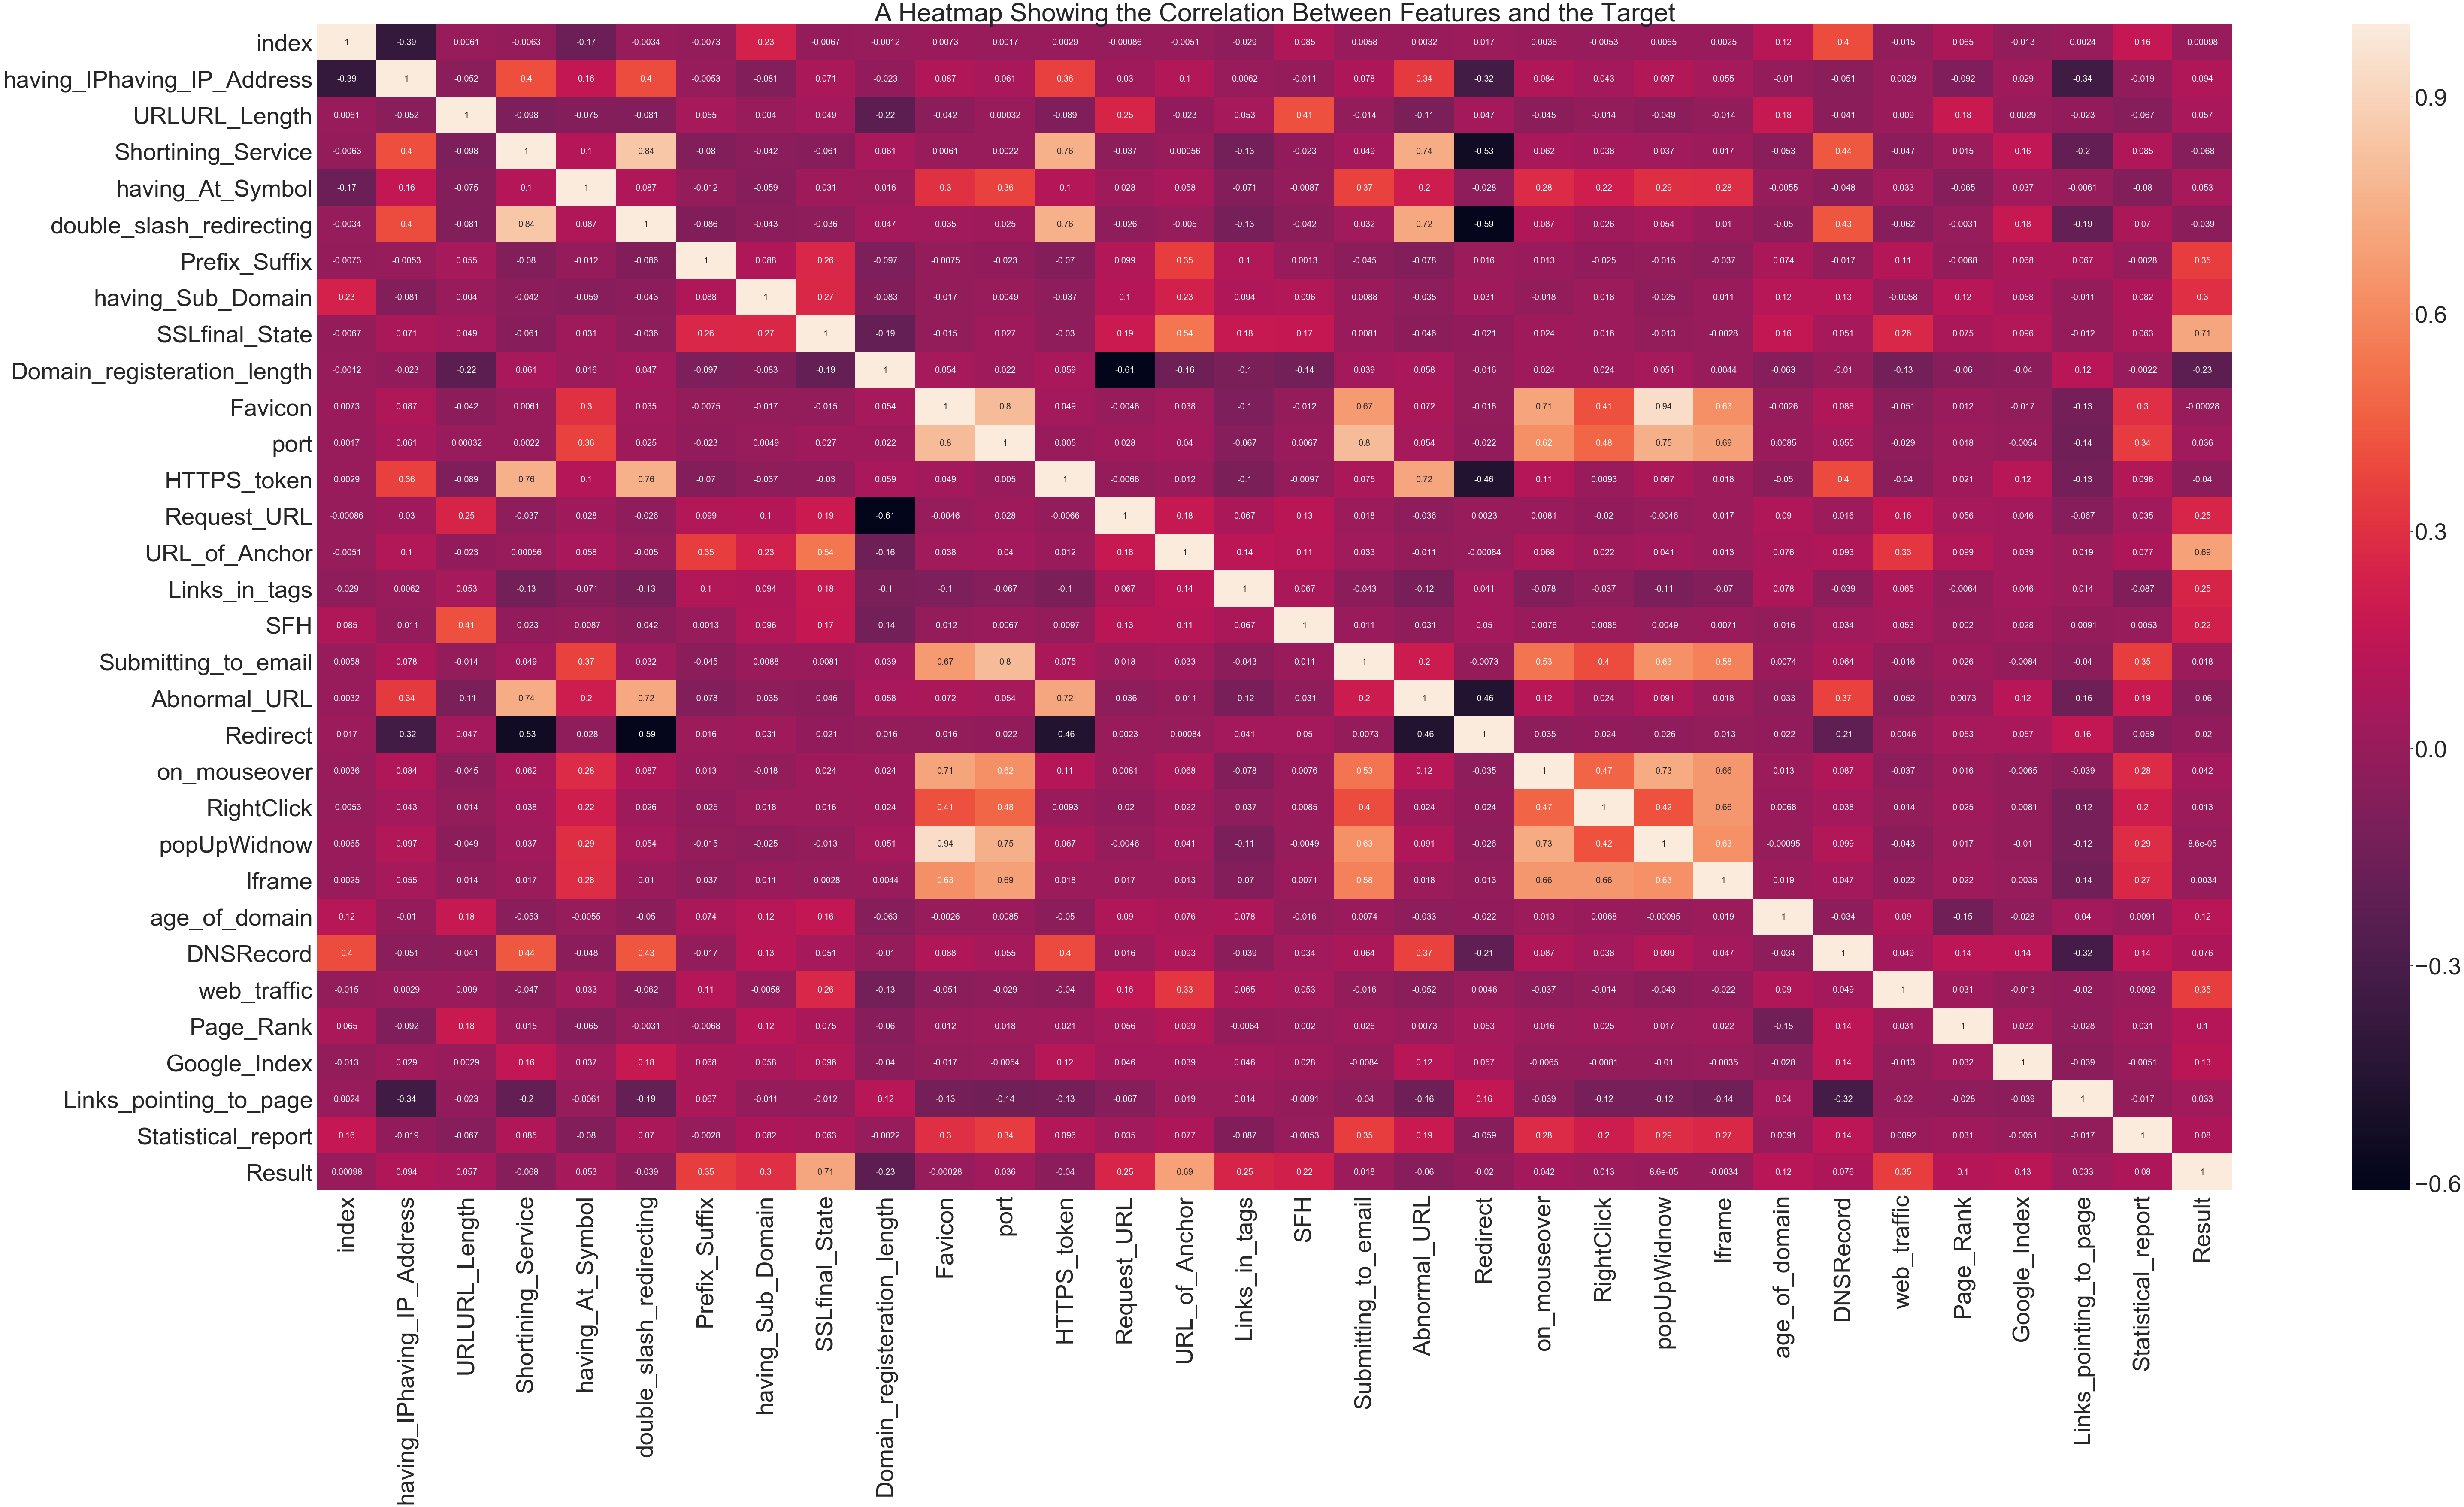

In [23]:
feature_corr = phishing_df.corr()
sns.set(font_scale=5)
sns.heatmap(data=feature_corr, annot=True, annot_kws={"size": 20})
plt.title("A Heatmap Showing the Correlation Between Features and the Target")
plt.show()

## Feature Selection

In [7]:
#Reference: Function adapted from the author of stepwise-regression
#Module: Stepwise Regression
#Author: Aakkash Vijayakumar
#URL: https://github.com/AakkashVijayakumar/stepwise-regression
#Date Retrieved: April 07, 2020

def forward_regression(X, y, threshold_in):
    
    initial_list = []
    included = list(initial_list)
    model = None
    
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
            
        best_pval = new_pval.min()
        
        ##Determining best predictor by comparing the one with the minimum p-value against the alpha value of 0.05
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            print('Feature Added: {0} with p-value {1}'.format(best_feature, round(best_pval, 5)))

        if not changed:
            break

    return [model, included]

In [8]:
X = phishing_df.iloc[:,0:-1]
y = phishing_df.iloc[:,-1]

usefule_features = forward_regression(X, y, 0.05)

C:\Users\pages\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Feature Added: Prefix_Suffix with p-value 0.0
Feature Added: SSLfinal_State with p-value 0.0
Feature Added: URL_of_Anchor with p-value 0.0
Feature Added: Links_in_tags with p-value 0.0
Feature Added: SFH with p-value 0.0
Feature Added: web_traffic with p-value 0.0
Feature Added: having_Sub_Domain with p-value 0.0
Feature Added: Request_URL with p-value 0.0
Feature Added: Google_Index with p-value 0.0
Feature Added: Links_pointing_to_page with p-value 0.0
Feature Added: having_IPhaving_IP_Address with p-value 0.0
Feature Added: Shortining_Service with p-value 0.0
Feature Added: DNSRecord with p-value 0.0
Feature Added: Redirect with p-value 0.0
Feature Added: Page_Rank with p-value 0.0
Feature Added: Statistical_report with p-value 0.0
Feature Added: having_At_Symbol with p-value 0.0
Feature Added: Abnormal_URL with p-value 0.0
Feature Added: URLURL_Length with p-value 0.00034
Feature Added: double_slash_redirecting with p-value 0.00153
Feature Added: HTTPS_token with p-value 0.00019
Fe

In [12]:
##
X = phishing_df[usefule_features[1]]
X.head()

,Prefix_Suffix,SSLfinal_State,URL_of_Anchor,Links_in_tags,SFH,web_traffic,having_Sub_Domain,Request_URL,Google_Index,Links_pointing_to_page,...,DNSRecord,Redirect,Page_Rank,Statistical_report,having_At_Symbol,Abnormal_URL,URLURL_Length,double_slash_redirecting,HTTPS_token,Iframe
0,-1,-1,-1,1,-1,-1,-1,1,1,1,...,-1,0,-1,-1,1,-1,1,-1,-1,1
1,-1,1,0,-1,-1,0,0,1,1,1,...,-1,0,-1,1,1,1,1,1,-1,1
2,-1,-1,0,-1,-1,1,-1,1,1,0,...,-1,0,-1,-1,1,-1,0,1,-1,1
3,-1,-1,0,0,-1,1,-1,-1,1,-1,...,-1,0,-1,1,1,1,0,1,-1,1
4,-1,1,0,0,-1,0,1,1,1,1,...,-1,0,-1,1,1,1,0,1,1,1


## Model Fitting

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Baseline Model: DecisionTree

In [33]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
decision_tree.score(X_train, y_train)

0.9822478516508367

In [34]:
decision_tree.score(X_test, y_test)

0.9538670284938942

### Random Forest Classifier

In [28]:
rf_model = RandomForestClassifier(n_estimators=300)
rf_model.fit(X_train, y_train)
rf_model.score(X_train, y_train)

0.9822478516508367

In [35]:
rf_model.score(X_test, y_test)

0.9665309814563546

### Xtreme Gradient Boosting

In [37]:
xgb_classifer = xgb.XGBClassifier(n_estimators=300, max_depth=5)
xgb_classifer.fit(X_train, y_train)
xgb_classifer.score(X_train, y_train)

0.975463591135233

In [38]:
xgb_classifer.score(X_test, y_test)

0.9624604251469923

In [40]:
score = cross_val_score(xgb_classifer, X_train, y_train, cv=5)
np.mean(score)

0.9629130557046809

### Multi Layer Perceptron

In [44]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 120), random_state=1)
mlp.fit(X_train, y_train)
mlp.score(X_train, y_train)

0.9822478516508367

In [45]:
mlp.score(X_test, y_test)

0.9638172772501131

## Voting Classifier: Ensemble of Ensembles

In [79]:
voting_classifier = VotingClassifier([('rf', rf_model), ('xgb', xgb_classifer), ('mlp', mlp)], voting='soft')
voting_classifier.fit(X_train, y_train)
voting_classifier.score(X_train, y_train)

0.9822478516508367

In [80]:
voting_classifier.score(X_test, y_test)

0.9669832654907282

## Area Under Curve

In [81]:
pred = voting_classifier.predict(X_test)
pred

array([-1,  1, -1, ..., -1,  1,  1], dtype=int64)

In [82]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

0.9667012858555886


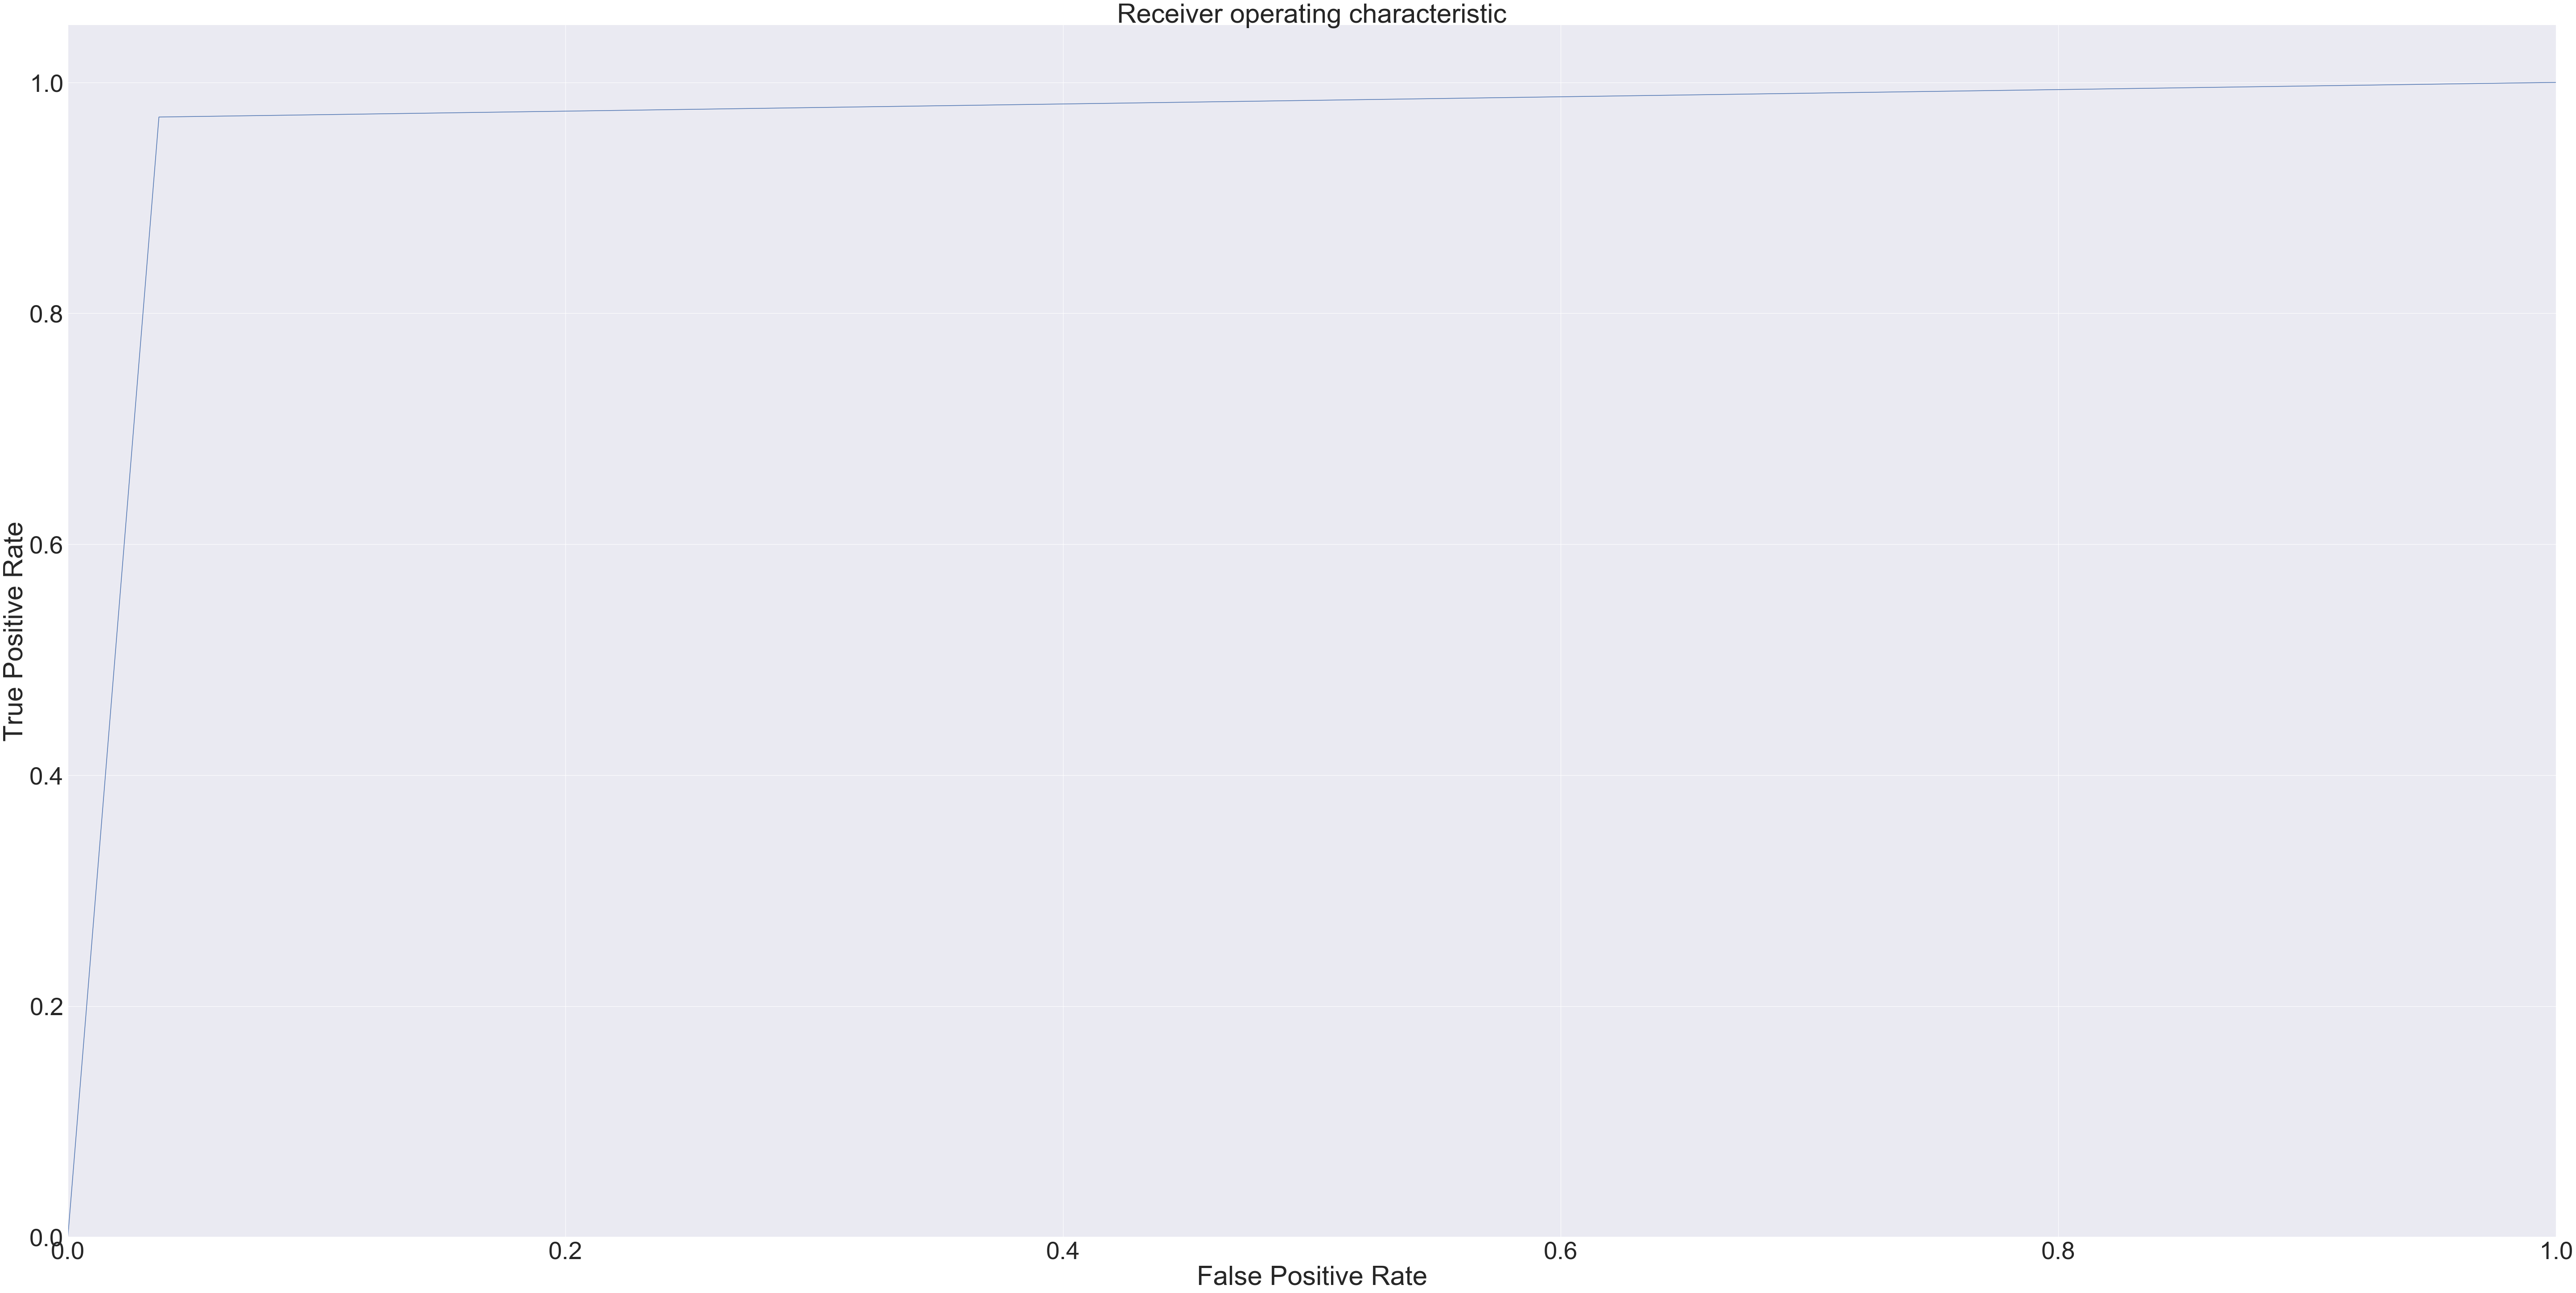

In [83]:

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

print(roc_auc_score(y_test, pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [76]:
tpr = np.mean((pred == 1) & (y_test == 1))
fpr = np.mean((pred == 1) & (y_test == -1))

In [77]:
tpr

0.5260063319764813

In [78]:
fpr

0.019448213478064226